In [4]:
from sklearn.datasets._samples_generator import make_blobs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np

In [5]:
random.seed(42)
rnd = random.randint(3, 10)

In [6]:
X, val = make_blobs(n_samples=500, centers=rnd, cluster_std=0.8, random_state=42)

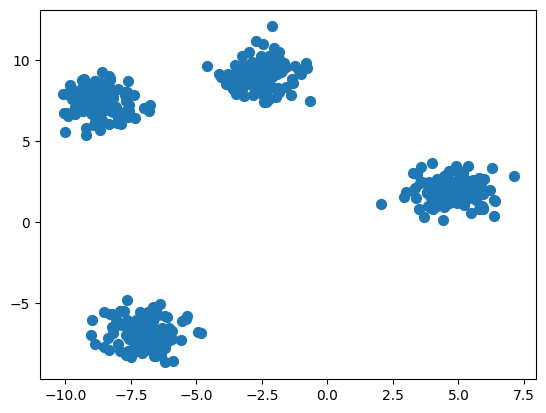

In [7]:
plt.scatter(X[:,0], X[:,1], s=50)

In [8]:
kmeans = KMeans(n_clusters=rnd)
kmeans.fit(X)
y = kmeans.predict(X)

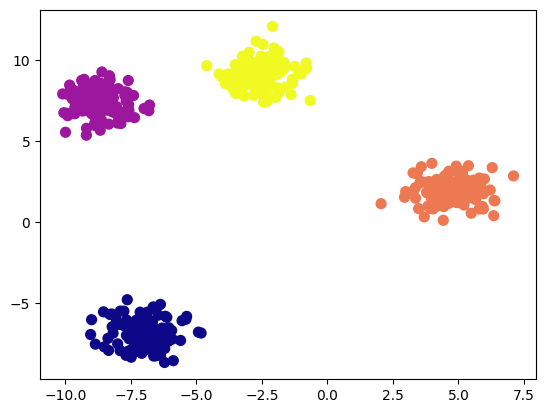

In [9]:
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap="plasma")
centroids = kmeans.cluster_centers_

In [10]:
def getBlobs(i):
  random.seed(i)
  nr = random.randint(3,10)
  return make_blobs(n_samples=500, centers=nr, cluster_std=0.8, random_state=nr*i)
  # plt.scatter(X[:,0],X[:,1])
  # plt.show()
  

In [11]:
X, val = getBlobs(10)

ssd = {}
for k in range(1,20):
  kmeans = KMeans(init="k-means++", n_clusters=k)
  kmeans.fit(X)
  ssd[k] = kmeans.inertia_
  
ssd

{1: 6881.244170618385,
 2: 2212.4399233175973,
 3: 613.9042274680983,
 4: 535.1142427209655,
 5: 464.0239113703921,
 6: 435.01286132958245,
 7: 354.0905046317846,
 8: 308.9922628584387,
 9: 289.30821708218025,
 10: 242.93069873733003,
 11: 234.11824050875475,
 12: 220.76699566825735,
 13: 196.6987943124354,
 14: 182.42298841272583,
 15: 182.2882980921218,
 16: 164.74911924280838,
 17: 154.00096083646895,
 18: 147.41735984569715,
 19: 145.08286145995245}

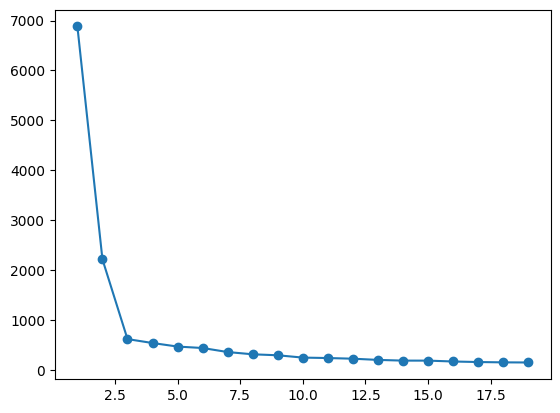

In [12]:
plt.plot(list(ssd.keys()), list(ssd.values()), marker="o")

probabilmente ci saranno 3 centroidi

In [13]:
kmeans_def = KMeans(init="k-means++", n_clusters=3)
kmeans_def.fit(X)
y_def = kmeans_def.predict(X)

In [14]:
centroids_def = kmeans_def.cluster_centers_

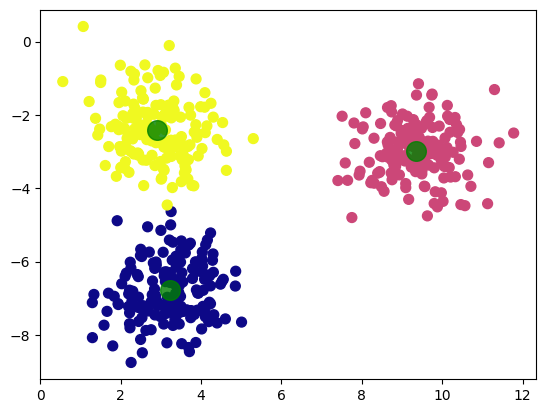

In [18]:
plt.scatter(X[:,0], X[:,1], c=y_def, s=50, cmap="plasma")
plt.scatter(centroids_def[:, 0], centroids_def[:, 1], c='green', s=200, alpha=0.8)

ora proviamo ad esplorare se esiste un modo automatico per eseguire il controllo sulla clusterizzazione

In [20]:
from scipy.signal import savgol_filter

def trova_k_ottimale_gomito_robusto(k_range, inertias, use_smoothing=True, smoothing_window=5):
    if len(k_range) < 2:
        print("Sono necessari almeno 2 punti per il calcolo.")
        return None

    inertias_np = np.array(inertias)
    k_range_np = np.array(k_range)

    if use_smoothing:
        if smoothing_window < 3 or smoothing_window % 2 == 0:
            raise ValueError("smoothing_window deve essere un intero dispari >= 3.")
        if smoothing_window > len(inertias_np):
            print("Avviso: La finestra di smoothing è troppo grande per i dati. Smoothing disabilitato.")
            inertias_smoothed = inertias_np
        else:
            inertias_smoothed = savgol_filter(inertias_np, window_length=smoothing_window, polyorder=2)
    else:
        inertias_smoothed = inertias_np

    points = np.array(list(zip(k_range_np, inertias_smoothed)))
    p1 = points[0]
    p2 = points[-1]

    A = p2[1] - p1[1]
    B = p1[0] - p2[0]
    C = -A * p1[0] - B * p1[1]

    distances = []
    for i in range(len(points)):
        x0, y0 = points[i]
        distance = abs(A * x0 + B * y0 + C) / np.sqrt(A**2 + B**2 + 1e-10)

        distances.append(distance)

    optimal_k_index = np.argmax(distances)
    optimal_k = k_range_np[optimal_k_index]

    print(f"K ottimale stimato: {optimal_k} (Metodo distanza da linea, Smoothing: {use_smoothing})")

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertias, marker='o', label='Inerzia Originale')
    if use_smoothing:
        plt.plot(k_range_np, inertias_smoothed, marker='x', linestyle='--', color='orange', label='Inerzia Livigata')
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'r--', label='Linea di base')
    plt.plot(optimal_k, inertias_smoothed[optimal_k_index], 'go', markersize=10, label=f'Gomito stimato K={optimal_k}')
    plt.xlabel('Numero di Cluster (K)')
    plt.ylabel('Inerzia')
    plt.title('Metodo del Gomito (Robusto)')
    plt.grid(True)
    plt.xticks(k_range)
    plt.legend()
    plt.show()

    return optimal_k

K ottimale stimato: 3 (Metodo distanza da linea, Smoothing: True)


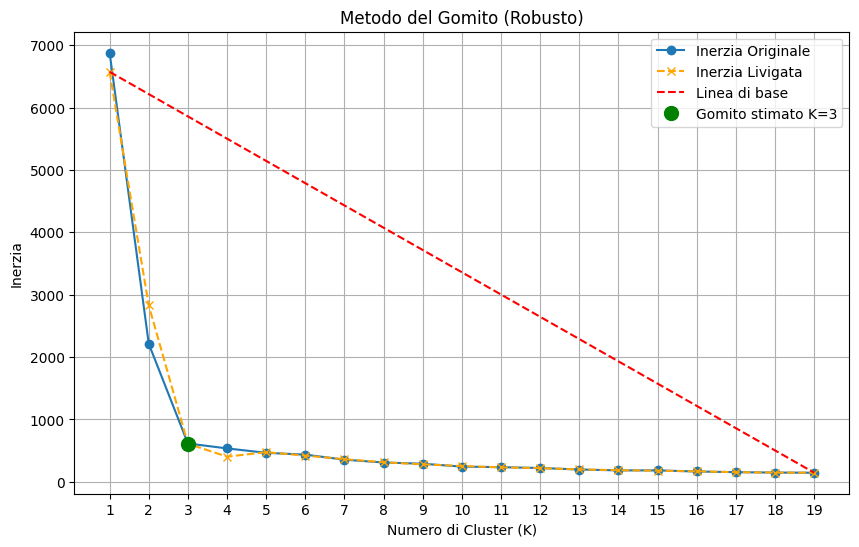

In [23]:
optimal_k = trova_k_ottimale_gomito_robusto(list(ssd.keys()), list(ssd.values()))

In [24]:
optimal_k

np.int64(3)